# Filtering large catalogs

Large astronomical surveys contain a massive volume of data. Billion-object, multi-terabyte-sized catalogs are challenging to store and manipulate because they demand state-of-the-art hardware. Processing them is expensive, both in terms of runtime and memory consumption, and doing so on a single machine has become impractical. LSDB is a solution that enables scalable algorithm execution. It handles loading, querying, filtering, and crossmatching astronomical data (of HATS format) in a distributed environment. 

In this tutorial, we will demonstrate how to:

1. Set up a Dask client for distributed processing
2. Load an object catalog with a set of desired columns
3. Select data from regions of the sky
4. Preview catalog data

In [1]:
import lsdb

## Creating a Dask client

Dask is a framework that allows us to take advantage of distributed computing capabilities. 

With Dask, the operations defined in a workflow (e.g. this notebook) are added to a task graph which optimizes their order of execution. The operations are not immediately computed; that's for us to decide. As soon as we trigger the computations, Dask distributes the workload across its multiple workers, and tasks are run efficiently in parallel. Usually, the later we kick off the computations, the better.

Dask creates a client by default, if we do not instantiate one. If we do, we may set options such as:

- Specify the number of workers and the memory limit for each of them.
- Adjust the address for the dashboard that profiles the operations while they run (by default, it serves on port _8787_).

For additional information, please refer to https://distributed.dask.org/en/latest/client.html.

In [2]:
from dask.distributed import Client

client = Client(n_workers=4, memory_limit="auto")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 8.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:53722,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 8.00 GiB
Comm: tcp://127.0.0.1:53733,Total threads: 2
Dashboard: http://127.0.0.1:53740/status,Memory: 2.00 GiB
Nanny: tcp://127.0.0.1:53725,


## Loading a catalog

We will load a small 5 degree radius cone from the `ZTF DR14` object catalog. 

Catalogs represent tabular data and are internally subdivided into partitions based on their positions in the sky. When processing a catalog, each worker is expected to be able to load a single partition at a time into memory for processing. Therefore, when loading a catalog, it's crucial to __specify the subset of columns__ we need for our science pipeline. Failure to specify these columns results in loading the entire partition table, which not only increases the usage of worker memory, but also impacts runtime performance significantly.

In [3]:
surveys_path = "https://data.lsdb.io/hats/"

In [4]:
ztf_object_path = f"{surveys_path}/ztf_dr14/ztf_object"
ztf_object = lsdb.read_hats(ztf_object_path, columns=["ps1_objid", "ra", "dec"])
ztf_object

,ps1_objid,ra,dec
npartitions=2352,,,
0,int64[pyarrow],double[pyarrow],double[pyarrow]
4503599627370496,...,...,...
...,...,...,...
3457638613913698304,...,...,...
3458764513820540928,...,...,...


The catalog has been loaded lazily: we can see its metadata, but no actual data is there yet. We will be defining more operations in this notebook. Only when we call `compute()` on the resulting catalog are operations executed; i.e., data is loaded from disk into memory for processing.

## Selecting a region of the sky

We may use 3 types of spatial filters (cone, polygon and box) to select a portion of the sky. 

Filtering consists of two main steps:

- A __coarse__ stage, in which we find what pixels cover our desired region in the sky. These may overlap with the region and only be partially contained within the region boundaries. This means that some data points inside that pixel may fall outside of the region.

- A __fine__ stage, where we filter the data points from each pixel to make sure they fall within the specified region.

The `fine` parameter allows us to specify whether or not we desire to run the fine stage, for each search. It brings some overhead, so if your intention is to get a rough estimate of the data points for a region, you may disable it. It is always executed by default.

```
catalog.box_search(..., fine=False)
catalog.cone_search(..., fine=False)
catalog.polygon_search(..., fine=False)
```

Throughout this notebook, we will use the Catalog's `plot_pixels` method to display the HEALPix of each resulting catalog as filters are applied.

(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'ZTF_DR14 - pixel map'}>)

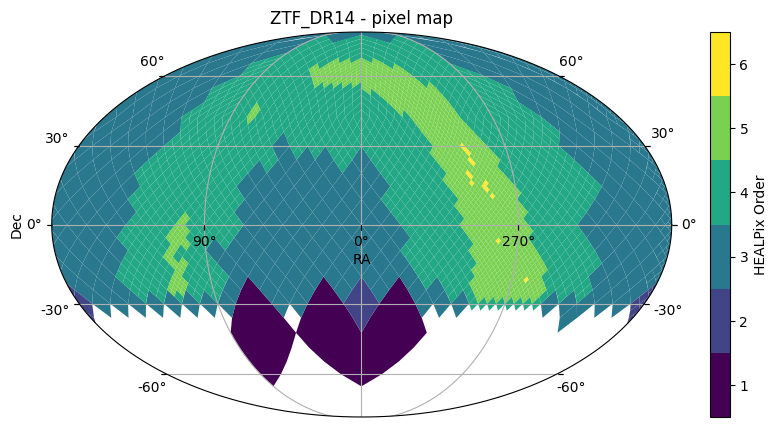

In [5]:
ztf_object.plot_pixels(plot_title="ZTF_DR14 - pixel map")

### Cone search

A cone search is defined by center `(ra, dec)`, in degrees, and radius `r`, in arcseconds.

In [6]:
ztf_object_cone = ztf_object.cone_search(ra=-60.3, dec=20.5, radius_arcsec=1 * 3600)
ztf_object_cone

,ps1_objid,ra,dec
npartitions=4,,,
911415974589104128,int64[pyarrow],double[pyarrow],double[pyarrow]
911697449565814784,...,...,...
913104824449368064,...,...,...
913386299426078720,...,...,...
913667774402789376,...,...,...


(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'ZTF_DR14 - cone pixel map'}>)

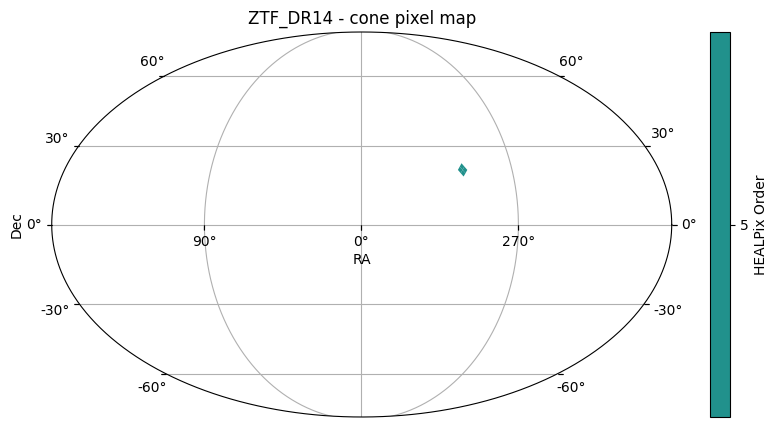

In [7]:
ztf_object_cone.plot_pixels(plot_title="ZTF_DR14 - cone pixel map")

### Polygon search

A polygon search is defined by convex polygon with vertices `[(ra1, dec1), (ra2, dec2)...]`, in degrees.

In [8]:
vertices = [(-60.5, 15.1), (-62.5, 18.5), (-65.2, 15.3), (-64.2, 12.1)]
ztf_object_polygon = ztf_object.polygon_search(vertices)
ztf_object_polygon

,ps1_objid,ra,dec
npartitions=14,,,
903534675241205760,int64[pyarrow],double[pyarrow],double[pyarrow]
909727124728840192,...,...,...
...,...,...,...
2159405652579975168,...,...,...
2159476021324152832,...,...,...


(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'ZTF_DR14 - polygon pixel map'}>)

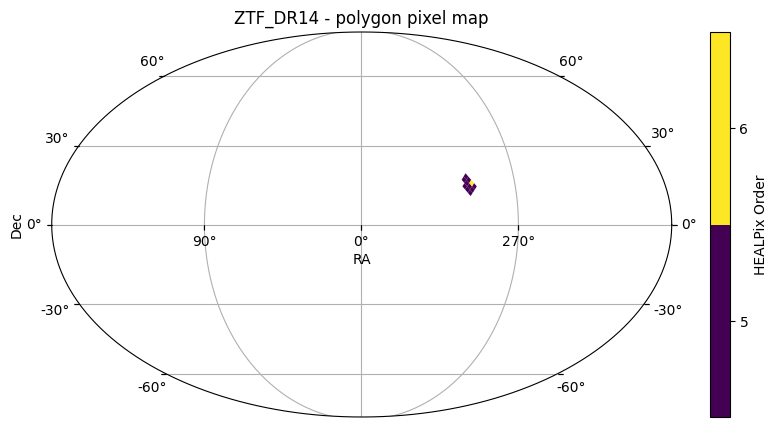

In [9]:
ztf_object_polygon.plot_pixels(plot_title="ZTF_DR14 - polygon pixel map")

### Box search

A box search can be defined by right ascension and declination bands `[(ra1, ra2), (dec1, dec2)]`.

In [10]:
ztf_object_box = ztf_object.box_search(ra=[-65, -60], dec=[12, 15])
ztf_object_box

,ps1_objid,ra,dec
npartitions=13,,,
902971725287784448,int64[pyarrow],double[pyarrow],double[pyarrow]
903534675241205760,...,...,...
...,...,...,...
2159194546347442176,...,...,...
2159264915091619840,...,...,...


(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'ZTF_DR14 - box pixel map'}>)

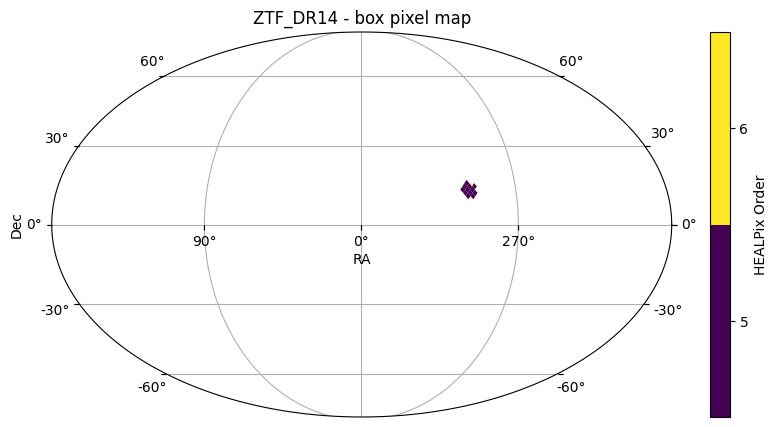

In [11]:
ztf_object_box.plot_pixels(plot_title="ZTF_DR14 - box pixel map")

We can stack a several number of filters, which are applied in sequence. For example, `catalog.box_search().polygon_search()` should result in a perfectly valid HATS catalog containing the objects that match both filters.

## Previewing part of the data

Computing an entire catalog requires loading all of its resulting data into memory, which is expensive and may lead to out-of-memory issues. 

Often, our goal is to have a peek at a slice of data to make sure the workflow output is reasonable (e.g., to assess if some new created columns are present and their values have been properly processed). `head()` is a pandas-like method which allows us to preview part of the data for this purpose. It iterates over the existing catalog partitions, in sequence, and finds up to `n` number of rows.

Notice that this method implicitly calls `compute()`.

In [12]:
ztf_object_cone.head()

/Users/scampos/anaconda3/envs/lsdb/lib/python3.10/asyncio/sslproto.py:320: ResourceWarning: unclosed transport <asyncio.sslproto._SSLProtocolTransport object at 0x292c1cbe0>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)


,ps1_objid,ra,dec
_healpix_29,,,
911529154909966282,131432999494754032,299.949481,19.527901
911529155126223541,131432999482554346,299.948273,19.52819
911529155242127522,131432999472704717,299.94726,19.528454
911529155485125949,131432999480965958,299.948077,19.529494
911529187674910393,131442999840264659,299.984096,19.536824


By default, the first 5 rows of data will be shown, but we can specify a higher number if we need.

In [13]:
ztf_object_cone.head(n=10)

,ps1_objid,ra,dec
_healpix_29,,,
911529154909966282,131432999494754032,299.949481,19.527901
911529155126223541,131432999482554346,299.948273,19.52819
911529155242127522,131432999472704717,299.94726,19.528454
911529155485125949,131432999480965958,299.948077,19.529494
911529187674910393,131442999840264659,299.984096,19.536824
911529188229036449,131442999792923350,299.979209,19.535608
911529188263890495,131442999803743832,299.980368,19.536026
911529188455674744,131442999770212613,299.977055,19.535172
911529188571457488,131442999775374201,299.977557,19.536359


## Closing the Dask client

In [14]:
client.close()